In [2]:
import easyocr
from pypdf import PdfReader
import pymupdf
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import polars as pl
import pytesseract
import cv2
PDF_PATH = "_test_pdfs/book1.pdf"
CONTENTS_PAGES = [5, 6]
# CONTENTS_PAGES = [2, 3]

In [3]:
def is_twopage(page_image):
    return page_image.shape[1] > page_image.shape[0]

def plot_pages(page_imgs):
    fig = plt.figure(figsize=(10, 10), dpi=300)
    for i, _img in enumerate(page_imgs):
        ax = fig.add_subplot(1, len(page_imgs), i+1)
        ax.imshow(_img, cmap="gray")
        ax.axis("off")
        ax.set_title(f"Page {i+1}")

In [4]:
doc = pymupdf.open(PDF_PATH)
# reader = easyocr.Reader(['en'])

page_imgs = []

two_page = False

for pagenum in tqdm(CONTENTS_PAGES):
    page = doc.load_page(pagenum)
    pixmap: pymupdf.Pixmap = page.get_pixmap(dpi=200)
    page_img = pixmap.pil_image()
    page_img = np.array(page_img)
    page_img = cv2.cvtColor(page_img, cv2.COLOR_RGB2GRAY)
    page_imgs.append(page_img)
    # if is_twopage(page_img):
    #     page_imgs.append(page_img[:, :page_img.shape[1]//2])
    #     page_imgs.append(page_img[:, page_img.shape[1]//2:])
    # else:
    #     page_imgs.append(page_img)

100%|██████████| 2/2 [00:00<00:00,  9.66it/s]


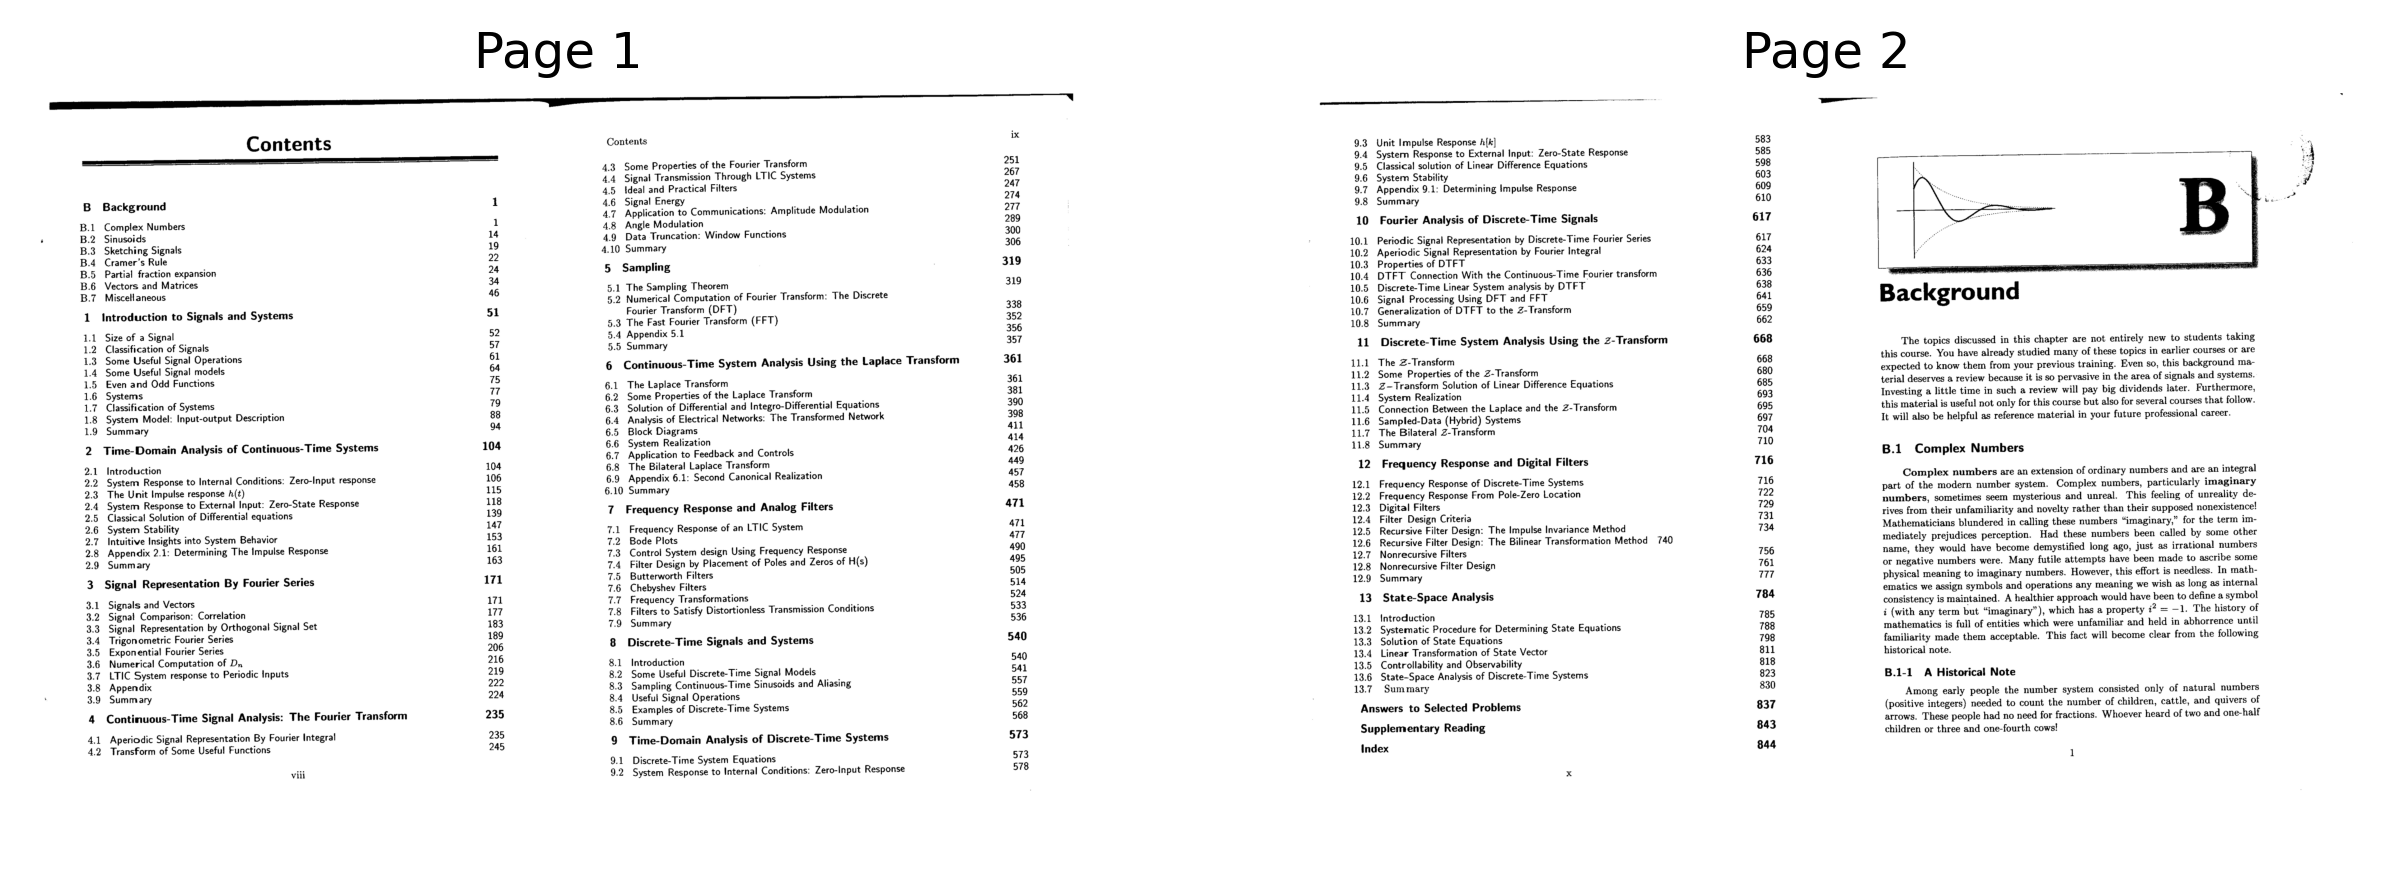

In [5]:
plot_pages(page_imgs)

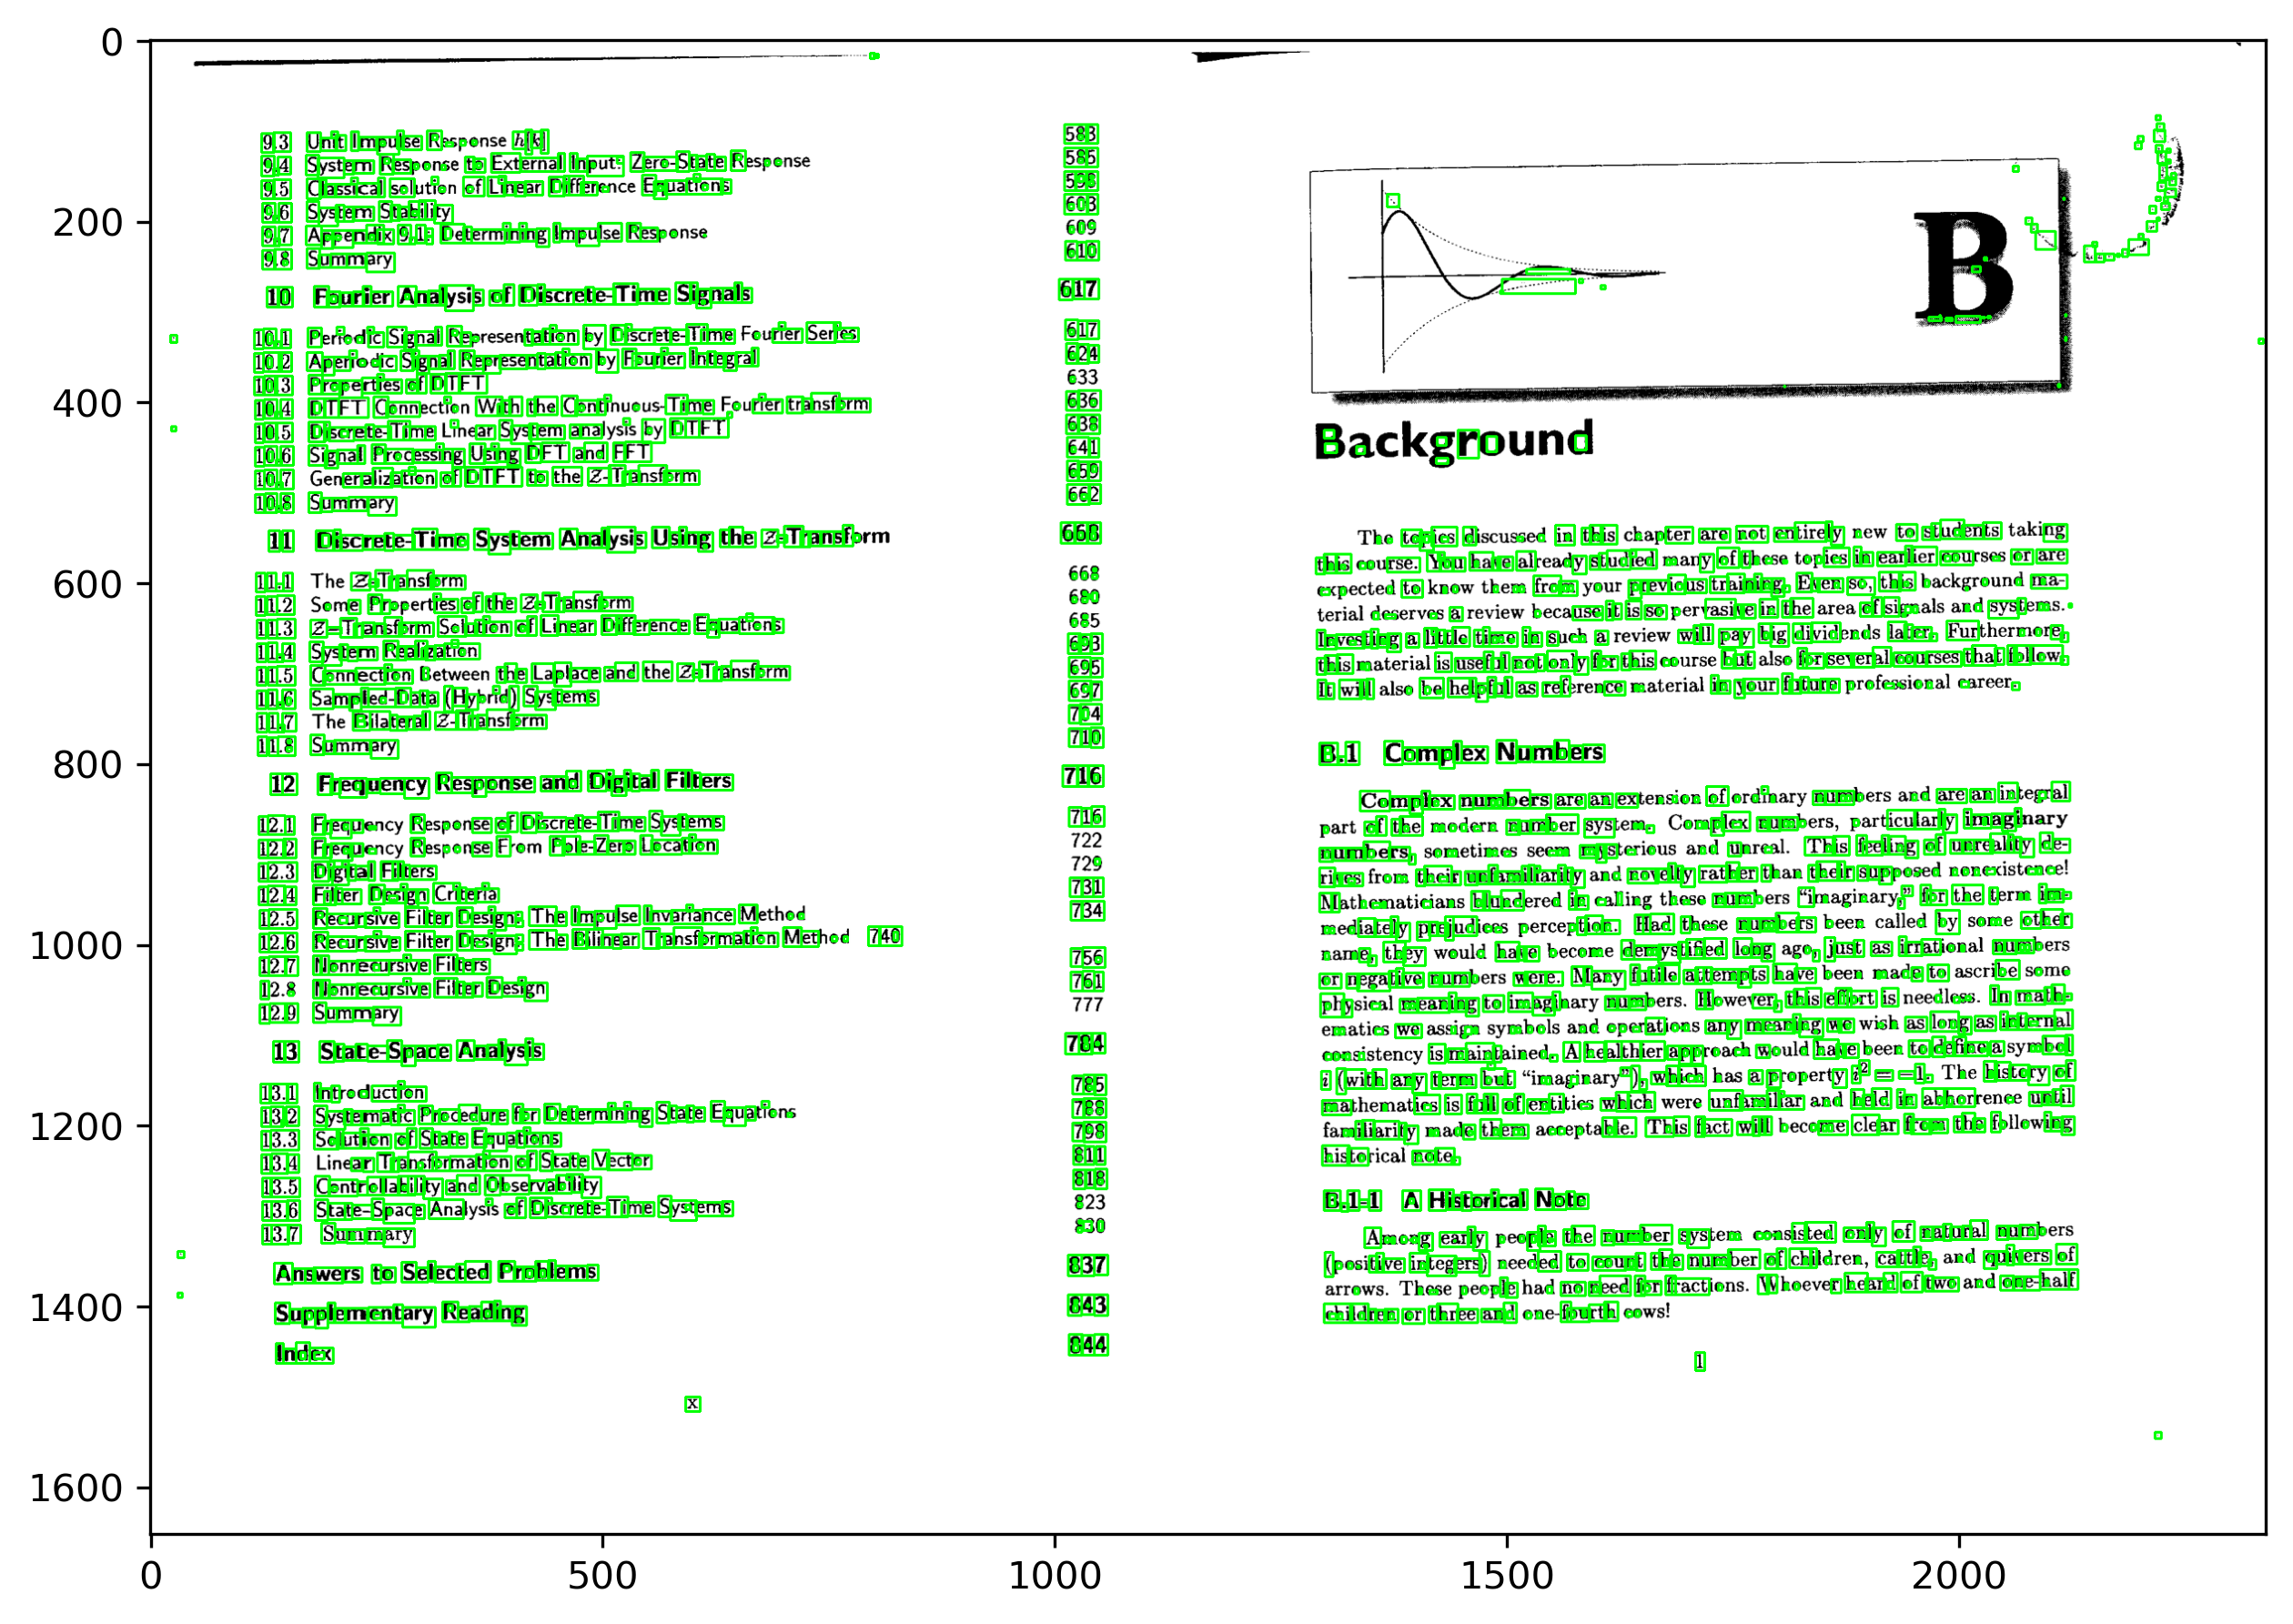

In [6]:
plt.figure(figsize=(10, 10), dpi=300)
imgimg = page_imgs[1]
blur = cv2.GaussianBlur(imgimg, (11, 11), 0)
# _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
original = cv2.cvtColor(imgimg, cv2.COLOR_GRAY2BGR)
for c in contours:
    if cv2.contourArea(c) > 400:
        continue
    x, y, w, h = cv2.boundingRect(c)
    cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 2)



plt.imshow(original, cmap="gray")

In [7]:
def detect_rotation(img):
    plt.figure(figsize=(10, 10), dpi=300)
    blur = cv2.GaussianBlur(img, (11, 11), 0)
    # a, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    original = img.copy()
    original = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    # # cnt = max(contours, key=cv2.contourArea)
    # # img = cv2.drawContours(original, [cnt], 0, (0, 255, 0), 3)

    

    angles = [0]
    for cnt in tqdm(contours):
        # print(cv2.contourArea(cnt))
        if cv2.contourArea(cnt) > 400:
            continue

        # x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.array(box, dtype="int")
        start = box[0]
        end = box[3]

        dx = end[0] - start[0]
        dy = end[1] - start[1]

        angle = np.arctan2(dy, dx) * 180.0 / np.pi
        if angle < 5:
            angles.append(angle)

        
        # cv2.putText(original, f"{angle:.2f}", (start[0], start[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (100, 0, 0), 2)
        # cv2.drawContours(original, [box], 0, (0, 255, 0), 3)

    # print(np.mean(angles))
    # cv2.drawContours(original, contours, -1, (0, 255, 0), 3)
    # plt.imshow(b, cmap="gray")
    return np.mean(angles)

# page_imgs[0]
detect_rotation(page_imgs[1])

100%|██████████| 3033/3033 [00:00<00:00, 141582.44it/s]


-0.8782172784437327

<Figure size 3000x3000 with 0 Axes>

In [8]:
import scipy.ndimage

# rotate_amount = detect_rotation(page_imgs[0])

for i, page_img in enumerate(page_imgs):
    angle = detect_rotation(page_img)
    page_imgs[i] = scipy.ndimage.rotate(page_img, angle)
    # page_imgs[i] = scipy.ndimage.rotate(page_img, angle)

100%|██████████| 3033/3033 [00:00<00:00, 148537.25it/s]


<Figure size 3000x3000 with 0 Axes>

<Figure size 3000x3000 with 0 Axes>

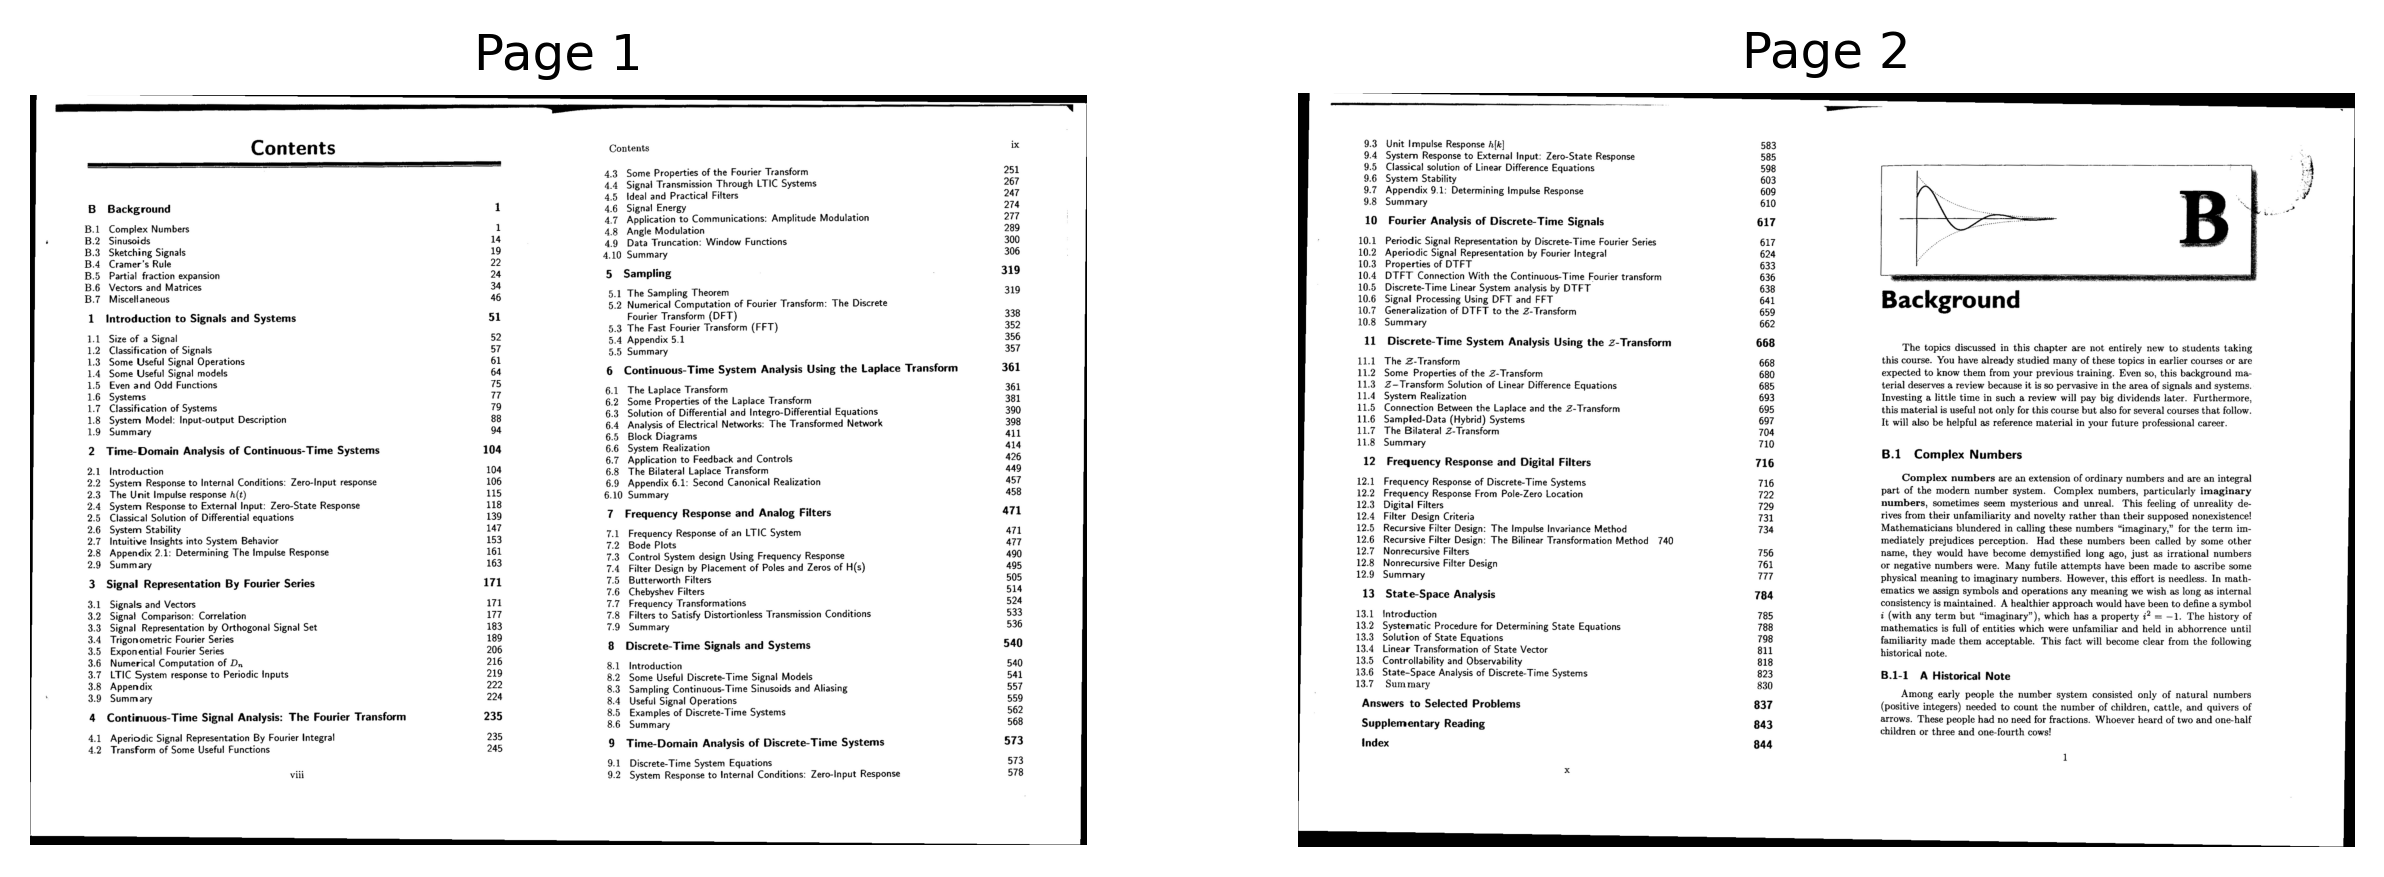

In [9]:
plot_pages(page_imgs)

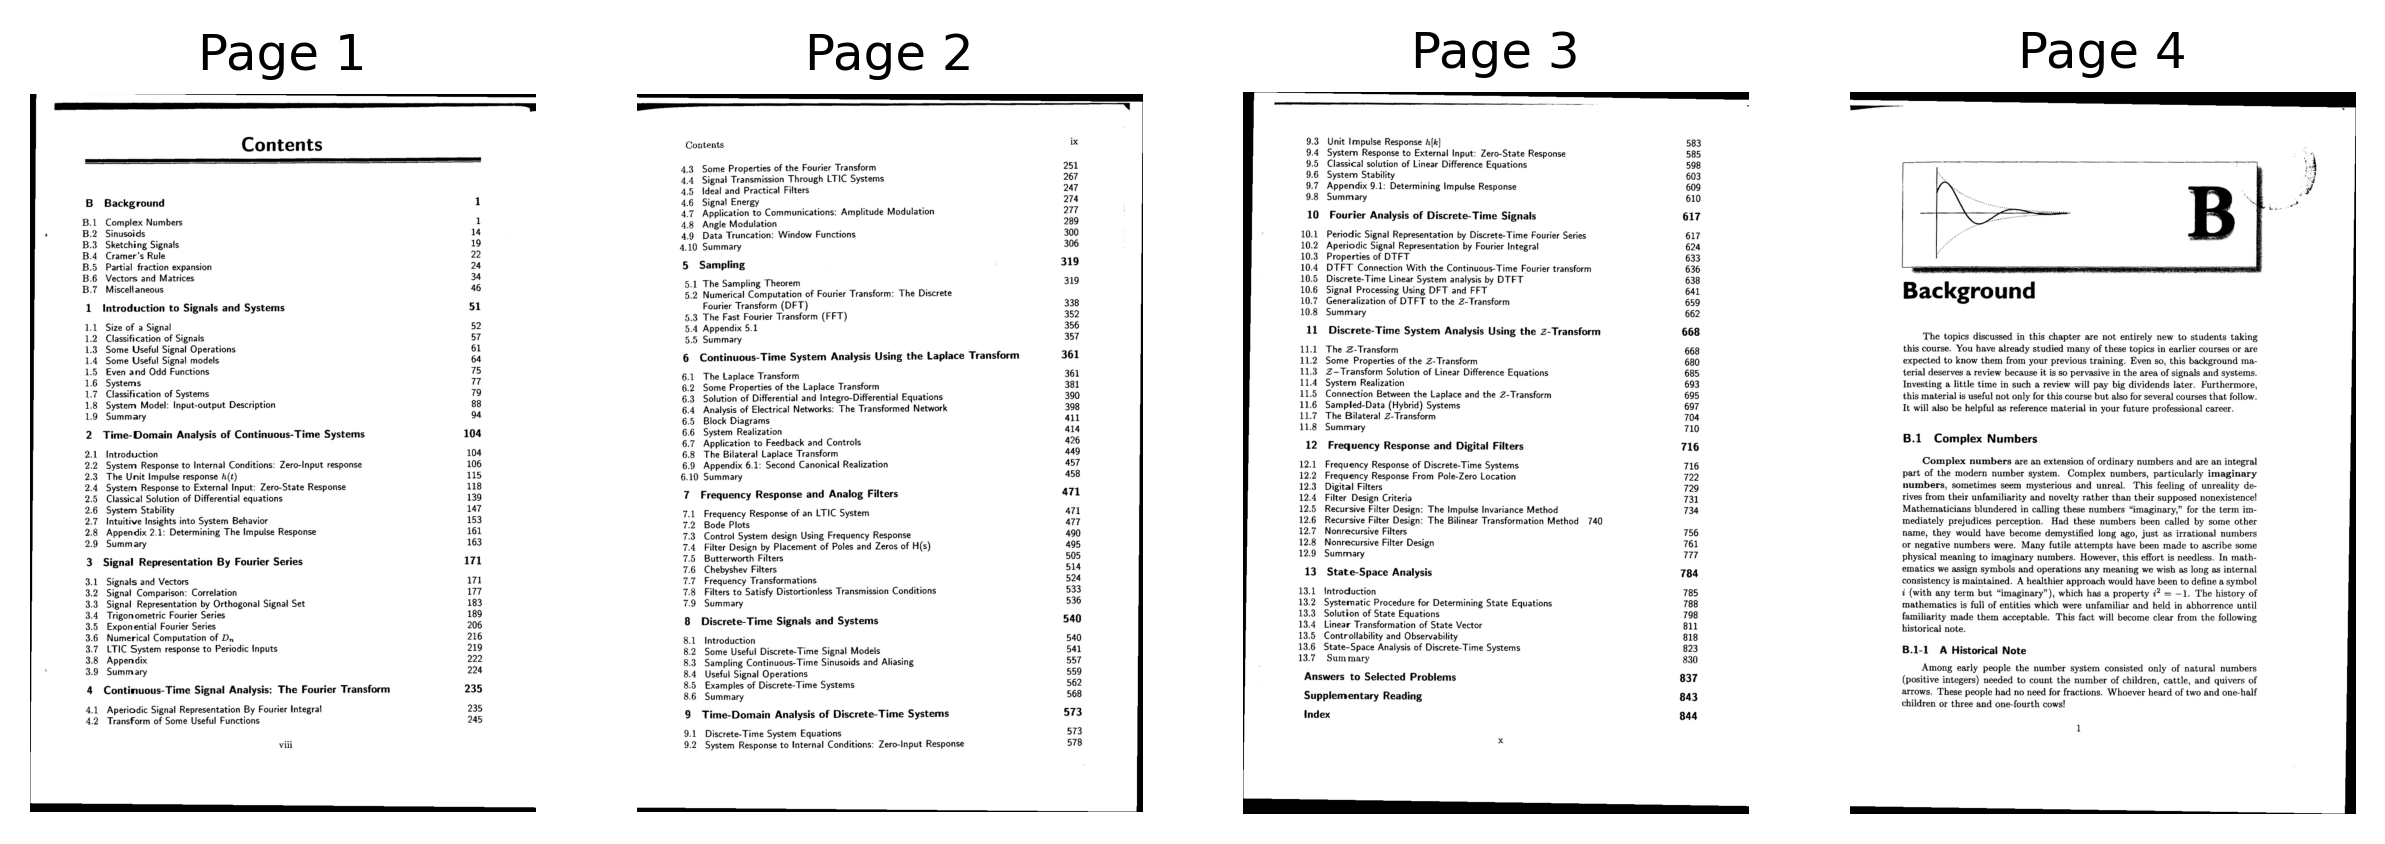

In [10]:
pages = []
two_page = False
for page_img in page_imgs:
    if is_twopage(page_img):
        pages.append(page_img[:, :page_img.shape[1]//2])
        pages.append(page_img[:, page_img.shape[1]//2:])
        two_page = True
    else:
        pages.append(page_img)

plot_pages(pages)

In [11]:
reader = easyocr.Reader(['en'])
detections = []

for i,page in enumerate(pages):
    page_detection = reader.detect(page, width_ths=2, height_ths=2)
    page_detection = page_detection[0][0]
    detections.append(page_detection)

In [12]:
def filter_horiz(item):
    width = item[1] - item[0]
    height = item[3] - item[2]
    return width > height

def filter_small(item):
    width = item[1] - item[0]
    height = item[3] - item[2]
    return np.abs(width - height) > 10

def map_widen(item, target_width):
    width = item[1] - item[0]
    height = item[3] - item[2]
    diff = target_width - width
    return [item[0], item[1] + diff, item[2], item[3]]

print(len(detections[0]))

detections = [list(filter(filter_horiz, d)) for d in detections]
detections = [list(filter(filter_small, d)) for d in detections]

page_width = pages[0].shape[1]

detections = [list(map(lambda x: map_widen(x, page_width), d)) for d in detections]



73


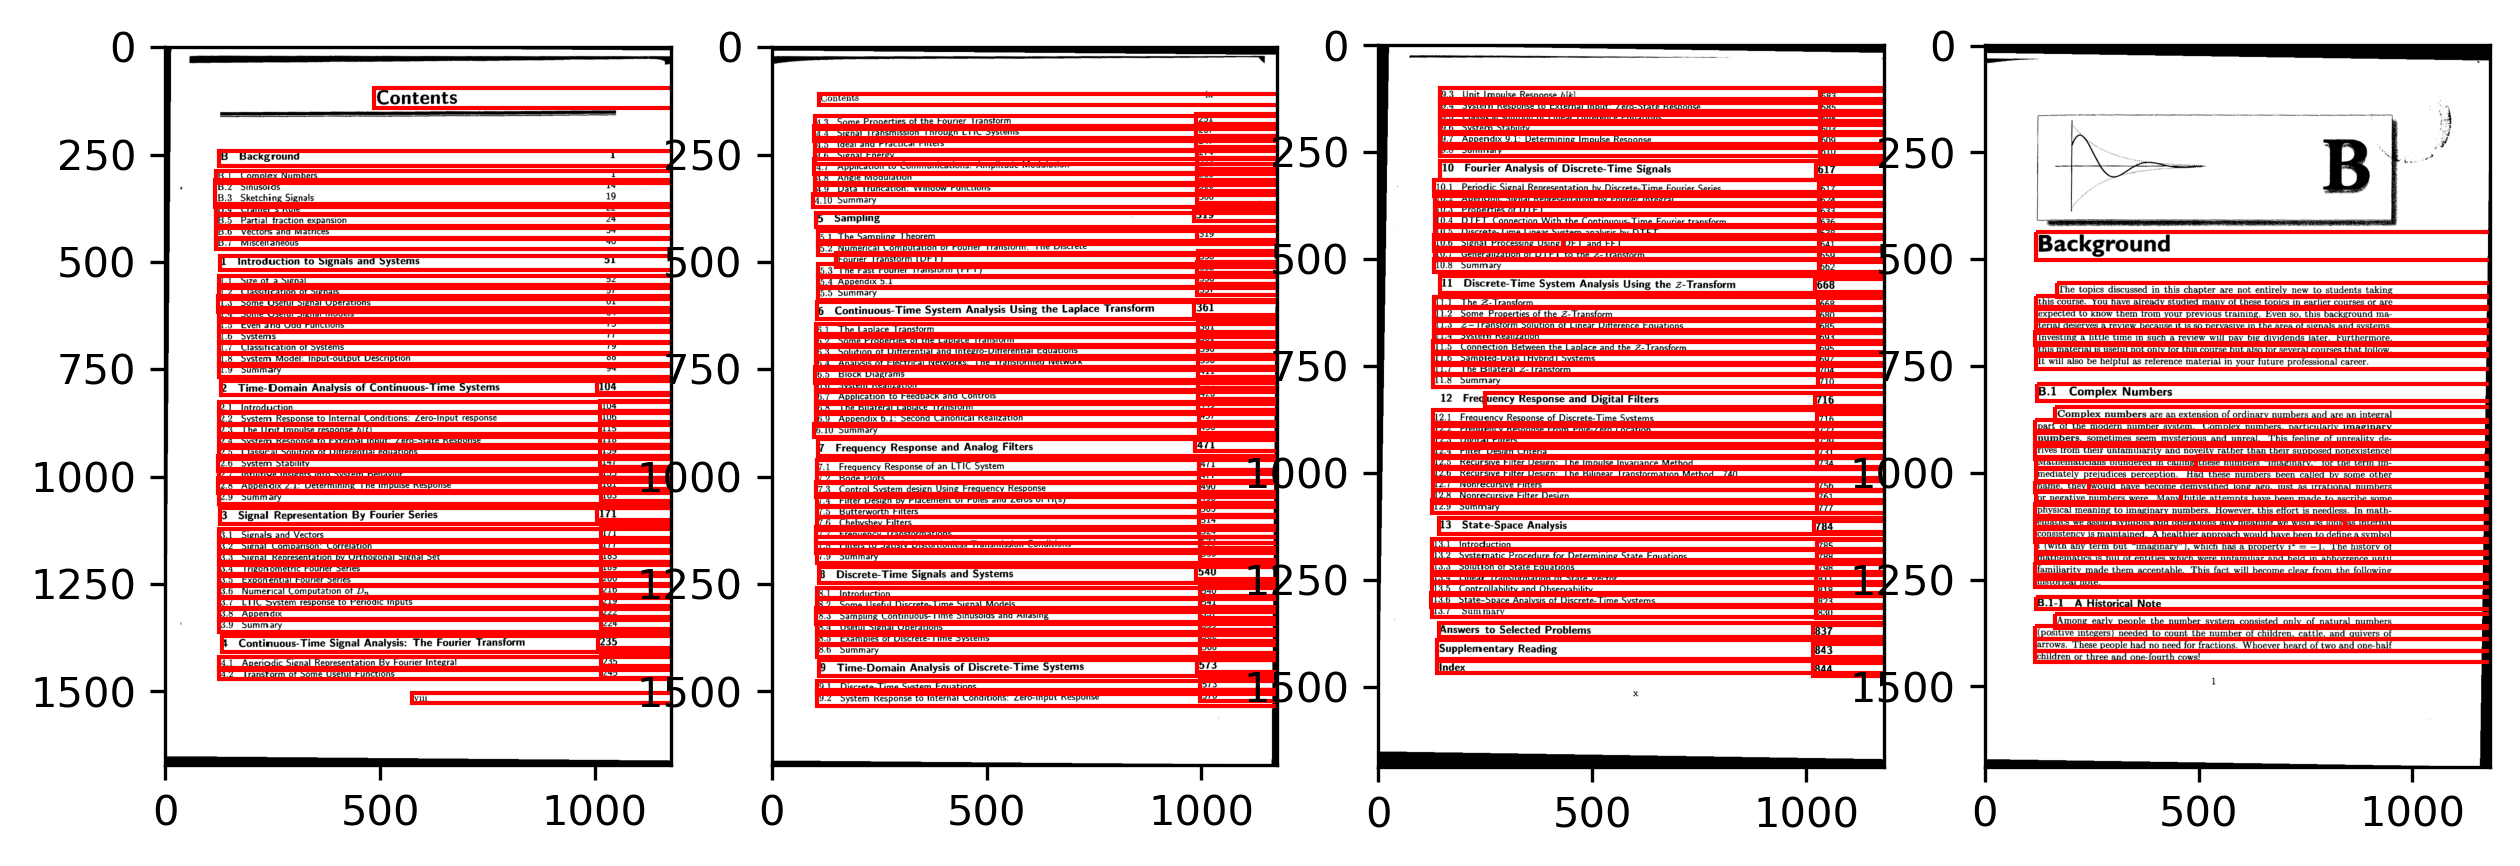

In [13]:
fig = plt.figure(figsize=(10, 10), dpi=300)
for i, page in enumerate(pages):
    ax = fig.add_subplot(1, len(pages), i+1)
    for detection in detections[i]:
        x1, x2, y1, y2 = detection
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    ax.imshow(page, cmap="gray")


In [14]:
texts = []
reader = easyocr.Reader(['en'])
for i, page in tqdm(enumerate(pages), total=len(pages)):
    page_detections = detections[i]
    page_texts = reader.recognize(page, horizontal_list=page_detections, free_list=[], blocklist=[","])
    texts.append(page_texts)

100%|██████████| 4/4 [00:09<00:00,  2.42s/it]


In [15]:
texts

[[([[486, 94], [1177, 94], [1177, 142], [486, 142]],
   'Contents',
   0.8040877883540077),
  ([[125, 241], [1177, 241], [1177, 277], [125, 277]],
   'B   Background 1',
   0.6434554994414173),
  ([[118, 288], [1177, 288], [1177, 316], [118, 316]],
   'B.l  Complex Numbers 1',
   0.8413121848959402),
  ([[115, 310], [1177, 310], [1177, 373], [115, 373]],
   'B3  Sietchidg Signals " `',
   0.5575720109944564),
  ([[118, 366], [1177, 366], [1177, 392], [118, 392]],
   "B.4   Cramer's Rule 22",
   0.6443324794122368),
  ([[118, 389], [1177, 389], [1177, 422], [118, 422]],
   'B.5   Partial fraction expansion 24',
   0.6816055611520828),
  ([[118, 417], [1177, 417], [1177, 447], [118, 447]],
   'B.6   Vectors and Matrices 34',
   0.5035132142188781),
  ([[118, 444], [1177, 444], [1177, 470], [118, 470]],
   'B.7   Miscellaneous 46',
   0.8391044898589898),
  ([[128, 486], [1177, 486], [1177, 518], [128, 518]],
   '1   Introduction to Signals and Systems 51',
   0.8702475508375995),
  ([[12

In [16]:
just_texts = []
for page in texts:
    for text in page:
        just_texts.append(text[1])

In [17]:
just_texts

['Contents',
 'B   Background 1',
 'B.l  Complex Numbers 1',
 'B3  Sietchidg Signals " `',
 "B.4   Cramer's Rule 22",
 'B.5   Partial fraction expansion 24',
 'B.6   Vectors and Matrices 34',
 'B.7   Miscellaneous 46',
 '1   Introduction to Signals and Systems 51',
 '1.1  Size of a Signal 52',
 '1.2   Classification of Signals 57',
 '1.3   Some Useful Signal Operations 61',
 '1.4   Some Useful Signal models 64',
 '1.5   Even and Odd Functions 75',
 '1.6   Systems 77',
 '1.7   Classification of Systems 79',
 '1.8   System Model: Input-output Description 88',
 '1.9   Summary 94',
 '2   Time-Domain Analysis of Continuous-Time Systems 104',
 '104',
 '2.1   Introduction 104',
 '104',
 '2.2   System Response to Internal Conditions: Zero-Input response 106',
 '106',
 '2.3   The Unit Impulse response h(t) 115',
 '115',
 '2.4   System Response to External Input: Zero-State Response 118',
 '118',
 '2.5   Classical Solution of Differential equations 139',
 '139',
 '2.6   System Stability` 147',
 

In [18]:
from openai import OpenAI
to_decode = "\n".join(just_texts)

client = OpenAI(
    base_url="https://api.omnistack.sh/openai/v1",
    api_key="osk_1a0e3e37aedbf2e3c37cdfcbb5e8901b"
)

completion = client.chat.completions.create(
    model="fred_winona_mariane",
    messages=[
        {
            'role': 'system',
            'content': 'You are to decode the text presented between the <INPUT></INPUT> tags as a table of contents. You should provide output in CSV format as such:\n section,heading,page,level\n where section is the section number, heading is the heading of the section, page is the page number, and level is the level of the heading. Top level entries have level 0, and it increases from there. Important: Only output the CSV. For example:\n 2.1,Introduction,1,0'
        },
        {
            'role': 'user',
            'content': f"<INPUT>{to_decode}</INPUT>",
        },
    ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content="section,heading,page,level\nB,Background,1,0\nB.1,Complex Numbers,1,1\nB.3,Sietchidg Signals,1,1\nB.4,Cramer's Rule,22,1\nB.5,Partial fraction expansion,24,1\nB.6,Vectors and Matrices,34,1\nB.7,Miscellaneous,46,1\n1,Introduction to Signals and Systems,51,0\n1.1,Size of a Signal,52,1\n1.2,Classification of Signals,57,1\n1.3,Some Useful Signal Operations,61,1\n1.4,Some Useful Signal models,64,1\n1.5,Even and Odd Functions,75,1\n1.6,Systems,77,1\n1.7,Classification of Systems,79,1\n1.8,System Model: Input-output Description,88,1\n1.9,Summary,94,1\n2,Time-Domain Analysis of Continuous-Time Systems,104,0\n2.1,Introduction,104,1\n2.2,System Response to Internal Conditions: Zero-Input response,106,1\n2.3,The Unit Impulse response h(t),115,1\n2.4,System Response to External Input: Zero-State Response,118,1\n2.5,Classical Solution of Differential equations,139,1\n2.6,System Stability,147,1\n2.7,Intuitive Insights into System Behavior,153,1\n2.8,Appendix 2.1: Deter

In [19]:
import io
import pandas as pd
df = pl.read_csv(io.StringIO(completion.choices[0].message.content))
df = df.with_row_index()
df = df.with_columns(
    level=pl.col('level')
        .cast(pl.Int64, strict=False)
        .fill_null(0),
    page=pl.col('page')
        .cast(pl.Int64, strict=False)
        .fill_null(0),
)
df

shape: (75, 5)
┌───────┬─────────┬─────────────────────────────────┬──────┬───────┐
│ index ┆ section ┆ heading                         ┆ page ┆ level │
│ ---   ┆ ---     ┆ ---                             ┆ ---  ┆ ---   │
│ u32   ┆ str     ┆ str                             ┆ i64  ┆ i64   │
╞═══════╪═════════╪═════════════════════════════════╪══════╪═══════╡
│ 0     ┆ B       ┆ Background                      ┆ 1    ┆ 0     │
│ 1     ┆ B.1     ┆ Complex Numbers                 ┆ 1    ┆ 1     │
│ 2     ┆ B.3     ┆ Sietchidg Signals               ┆ 1    ┆ 1     │
│ 3     ┆ B.4     ┆ Cramer's Rule                   ┆ 22   ┆ 1     │
│ 4     ┆ B.5     ┆ Partial fraction expansion      ┆ 24   ┆ 1     │
│ …     ┆ …       ┆ …                               ┆ …    ┆ …     │
│ 70    ┆ 7.5     ┆ Butterworth Filters             ┆ 505  ┆ 1     │
│ 71    ┆ 7.6     ┆ Chebyshev Filters               ┆ 514  ┆ 1     │
│ 72    ┆ 7.7     ┆ Frequency Transformations       ┆ 524  ┆ 1     │
│ 73    ┆ 7.8     ┆ Filters to Satisfy Distortionl… ┆ 533  ┆ 1     │
│ 74    ┆ 7       ┆ null                            ┆ 0    ┆ 0     │
└───────┴─────────┴─────────────────────────────────┴──────┴───────┘

In [20]:
import pypdf
from pypdf import PdfReader, PdfWriter

reader = PdfReader(PDF_PATH)
writer = PdfWriter(reader)

print(two_page)

hierarchy = [0]
items = []
last_level = 0
for row in df.iter_rows(named=True):

    if row["page"] > reader.get_num_pages():
        continue

    # if row["level"] > len(hierarchy) - 1:   
    #     print(row["level"], len(hierarchy)) 
    #     item = writer.add_outline_item(
    #         title=f"{row["heading"]} {row["level"]} {row["page"]}",
    #         # page_number=row["page"]//2 + 7,
    #         page_number=row["page"],
    #         parent=items[hierarchy[row["level"] - 1]],
    #     )
    # else:
    #     item = writer.add_outline_item(
    #         title=f"{row["heading"]} {row["level"]} {row["page"]}",
    #         # page_number=row["page"]//2 + 7,
    #         page_number=row["page"],
    #     )

    # if row["level"] == len(hierarchy) - 1:
    #     hierarchy[row["level"]] = row["index"]
    page_num = row["page"] 
    if two_page:
        page_num = page_num // 2 + CONTENTS_PAGES[-1]
    else:
        page_num = page_num + CONTENTS_PAGES[-1]

    item = writer.add_outline_item(
        title=f"{row["section"]} {row["heading"]} {row["level"]} {row["page"]}",
        # page_number=row["page"]//2 + 7,
        page_number=page_num,
    )
    # items.append(item)

writer.write("output.pdf")

True


(True, <_io.FileIO [closed]>)

In [21]:
print(completion.choices[0].message.content)

section,heading,page,level
B,Background,1,0
B.1,Complex Numbers,1,1
B.3,Sietchidg Signals,1,1
B.4,Cramer's Rule,22,1
B.5,Partial fraction expansion,24,1
B.6,Vectors and Matrices,34,1
B.7,Miscellaneous,46,1
1,Introduction to Signals and Systems,51,0
1.1,Size of a Signal,52,1
1.2,Classification of Signals,57,1
1.3,Some Useful Signal Operations,61,1
1.4,Some Useful Signal models,64,1
1.5,Even and Odd Functions,75,1
1.6,Systems,77,1
1.7,Classification of Systems,79,1
1.8,System Model: Input-output Description,88,1
1.9,Summary,94,1
2,Time-Domain Analysis of Continuous-Time Systems,104,0
2.1,Introduction,104,1
2.2,System Response to Internal Conditions: Zero-Input response,106,1
2.3,The Unit Impulse response h(t),115,1
2.4,System Response to External Input: Zero-State Response,118,1
2.5,Classical Solution of Differential equations,139,1
2.6,System Stability,147,1
2.7,Intuitive Insights into System Behavior,153,1
2.8,Appendix 2.1: Determining The Impulse Response,161,1
2.9,Summary,163,1
3,Sig